In [1]:
#--------------TuanPM 8/2020-------
#--------------Bearing fault classification-------
#import libs

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os



import copy
from livelossplot import PlotLosses
#from models import *
plt.ion()   # interactive mode

In [3]:
import numpy as np

#import optimizers with GC
from SGD import SGD_GCC,SGDW,SGDW_GCC
from Adam import Adam_GCC,AdamW,AdamW_GCC
from Adagrad import Adagrad_GCC

In [4]:
#import Data using Datat transform (pytorch)

In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),  
        #transforms.RandomAffine(degrees=(-5,5), translate=(0.2,0)),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),        
        #transforms.CenterCrop(224),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),        
        #transforms.CenterCrop(224),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './'
#image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          #data_transforms[x])
image_datasets = {x: datasets.ImageFolder(root='images/'+x,
                                          transform = data_transforms[x])
                  
                  for x in ['train', 'val','test']}
print(image_datasets)
batch_size = 4
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=41, #배치사이즈 원본 128/ 현재 16사용
                                             shuffle=True, num_workers=4)
               for x in ['train', 'val','test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

{'train': Dataset ImageFolder
    Number of datapoints: 4580
    Root location: images/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           ), 'val': Dataset ImageFolder
    Number of datapoints: 2203
    Root location: images/val
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           ), 'test': Dataset ImageFolder
    Number of datapoints: 1271
    Root location: images/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )}


device(type='cuda', index=0)

In [6]:
#show input data

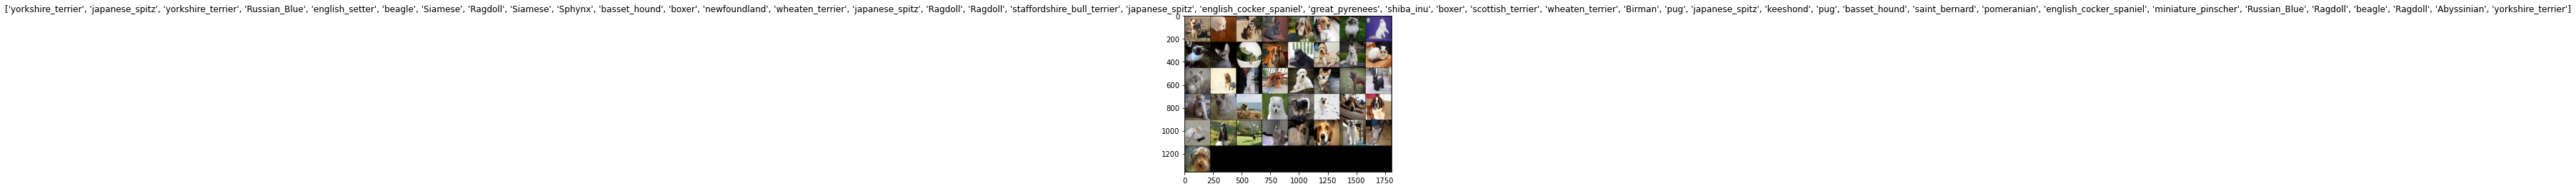

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [8]:
#initiate CNN model 

In [9]:
from models import *
import torch.nn as nn
import torch.nn.functional as F
model_name = 'resnet34'
net = resnet34()
net = net.to(device)
#사용하는 모델들
#ShuffleNetV2(n_class=2, input_size=224, width_mult=0.5)
#MobileNet2(scale=1.0, input_size=224, num_classes=2)
#squeezenet1_1()
#resnet34()
#vgg16(num_classes=2)


In [10]:
import torchvision.models as models
import torch
from ptflops import get_model_complexity_info
'''
with torch.cuda.device(0):
    macs, params = get_model_complexity_info(net, (3, 224, 224), as_strings=False, #here you need to change the image size according to your input image size 
                                           print_per_layer_stat=True, verbose=True)
    print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
    print('{:<30}  {:<8}'.format('Number of parameters: ', params))'''

"\nwith torch.cuda.device(0):\n    macs, params = get_model_complexity_info(net, (3, 224, 224), as_strings=False, #here you need to change the image size according to your input image size \n                                           print_per_layer_stat=True, verbose=True)\n    print('{:<30}  {:<8}'.format('Computational complexity: ', macs))\n    print('{:<30}  {:<8}'.format('Number of parameters: ', params))"

In [11]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
liveloss = PlotLosses()


optimizer = SGD_GCC(net.parameters(), lr = 0.002, momentum=0.9, weight_decay=0.0005)  #default learing rate : 0.002
                                                                                    #default momentum = 0.9, weight_decay = 0.0005

#optimizer = torch.optim.Adam(net.parameters(), lr=0.002)
#optimizer = torch.optim.Adamax(net.parameters(), lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0001)
#optimizer = sls.Sls(net.parameters())

In [12]:
#Training and validation Function

In [13]:
def train_model(model, criterion, optimizer, num_epochs=20):
    liveloss = PlotLosses()
    model = model.to(device)
    optimizer.zero_grad()
    
    #morph_optimizer = None
    
    for epoch in range(num_epochs):
        print(epoch)
        logs = {}
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    def closure():
                        probs = F.log_softmax(net(inputs), dim=1)
                        loss = F.nll_loss(probs, labels, reduction="sum")
                        return loss                    
                    loss.backward()
                    optimizer.step()#closure

                    
            # setup for comparing the morphed model
                    #if morph_optimizer:
                        #morph_optimizer.zero_grad()
                        #morph_loss = loss_fn(morph_model(input), target)

                        #logging.info(f'Morph loss - Standard loss = {morph_loss - loss}')

                        #morph_loss.backward()
                        #morph_optimizer.step()


    # Experimentally supported: Initialize our morphing halfway training
                    #if epoch == num_epochs // 2:
                      # if you want to override your model
                        #model = morph.once(model)

                      # if you want to compare in parallel
                        #morph_model = morph.once(model)

      # either way, you need to tell your optimizer about i
                        #morph_optimizer = init_optimizer(params=morph_model.parameters())
                    
                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
            prefix = ''
        
            if phase == 'val':
                prefix = 'val_'
            logs[prefix + 'log loss'] = epoch_loss.item()
            logs[prefix + 'accuracy'] = epoch_acc.item()
        print(epoch_loss.item())
        #plotter.plot('loss', 'train', 'Class Loss', epoch, epoch_loss)
        liveloss.update(logs)
        liveloss.draw()
        torch.save(net.state_dict(), PATH)
    #exp_lr_scheduler.step()

In [14]:
#define a path to save trained model and start to training

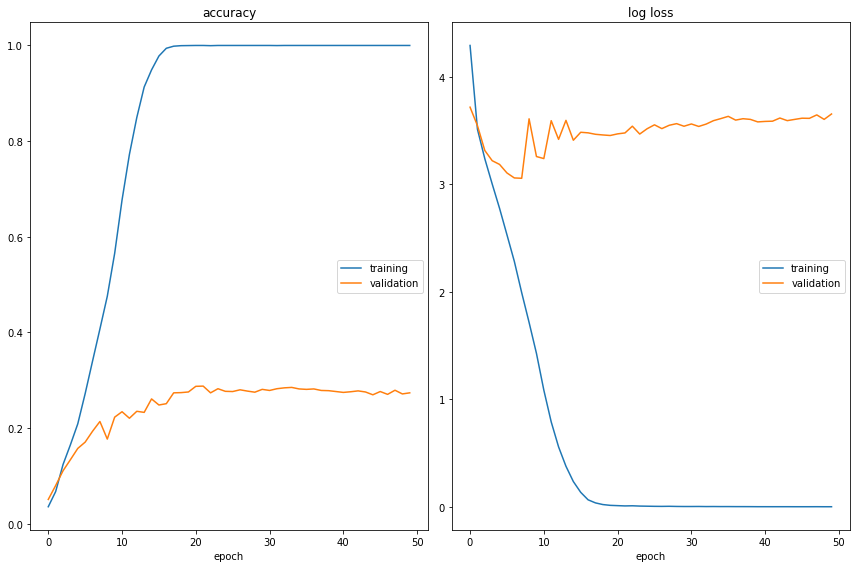

accuracy
	training         	 (min:    0.036, max:    1.000, cur:    1.000)
	validation       	 (min:    0.051, max:    0.288, cur:    0.274)
log loss
	training         	 (min:    0.002, max:    4.293, cur:    0.002)
	validation       	 (min:    3.057, max:    3.719, cur:    3.655)
Finish training!


In [15]:
PATH = './image1.pth' #change everytime you reconfig a new model
train_model(net, criterion, optimizer, num_epochs=50)#ok
print('Finish training!')

In [16]:
#confusion matrix

In [17]:
nb_classes = 41
net.load_state_dict(torch.load(PATH))

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['train']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = net(inputs).to(device)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
matrix_1 = confusion_matrix.numpy()

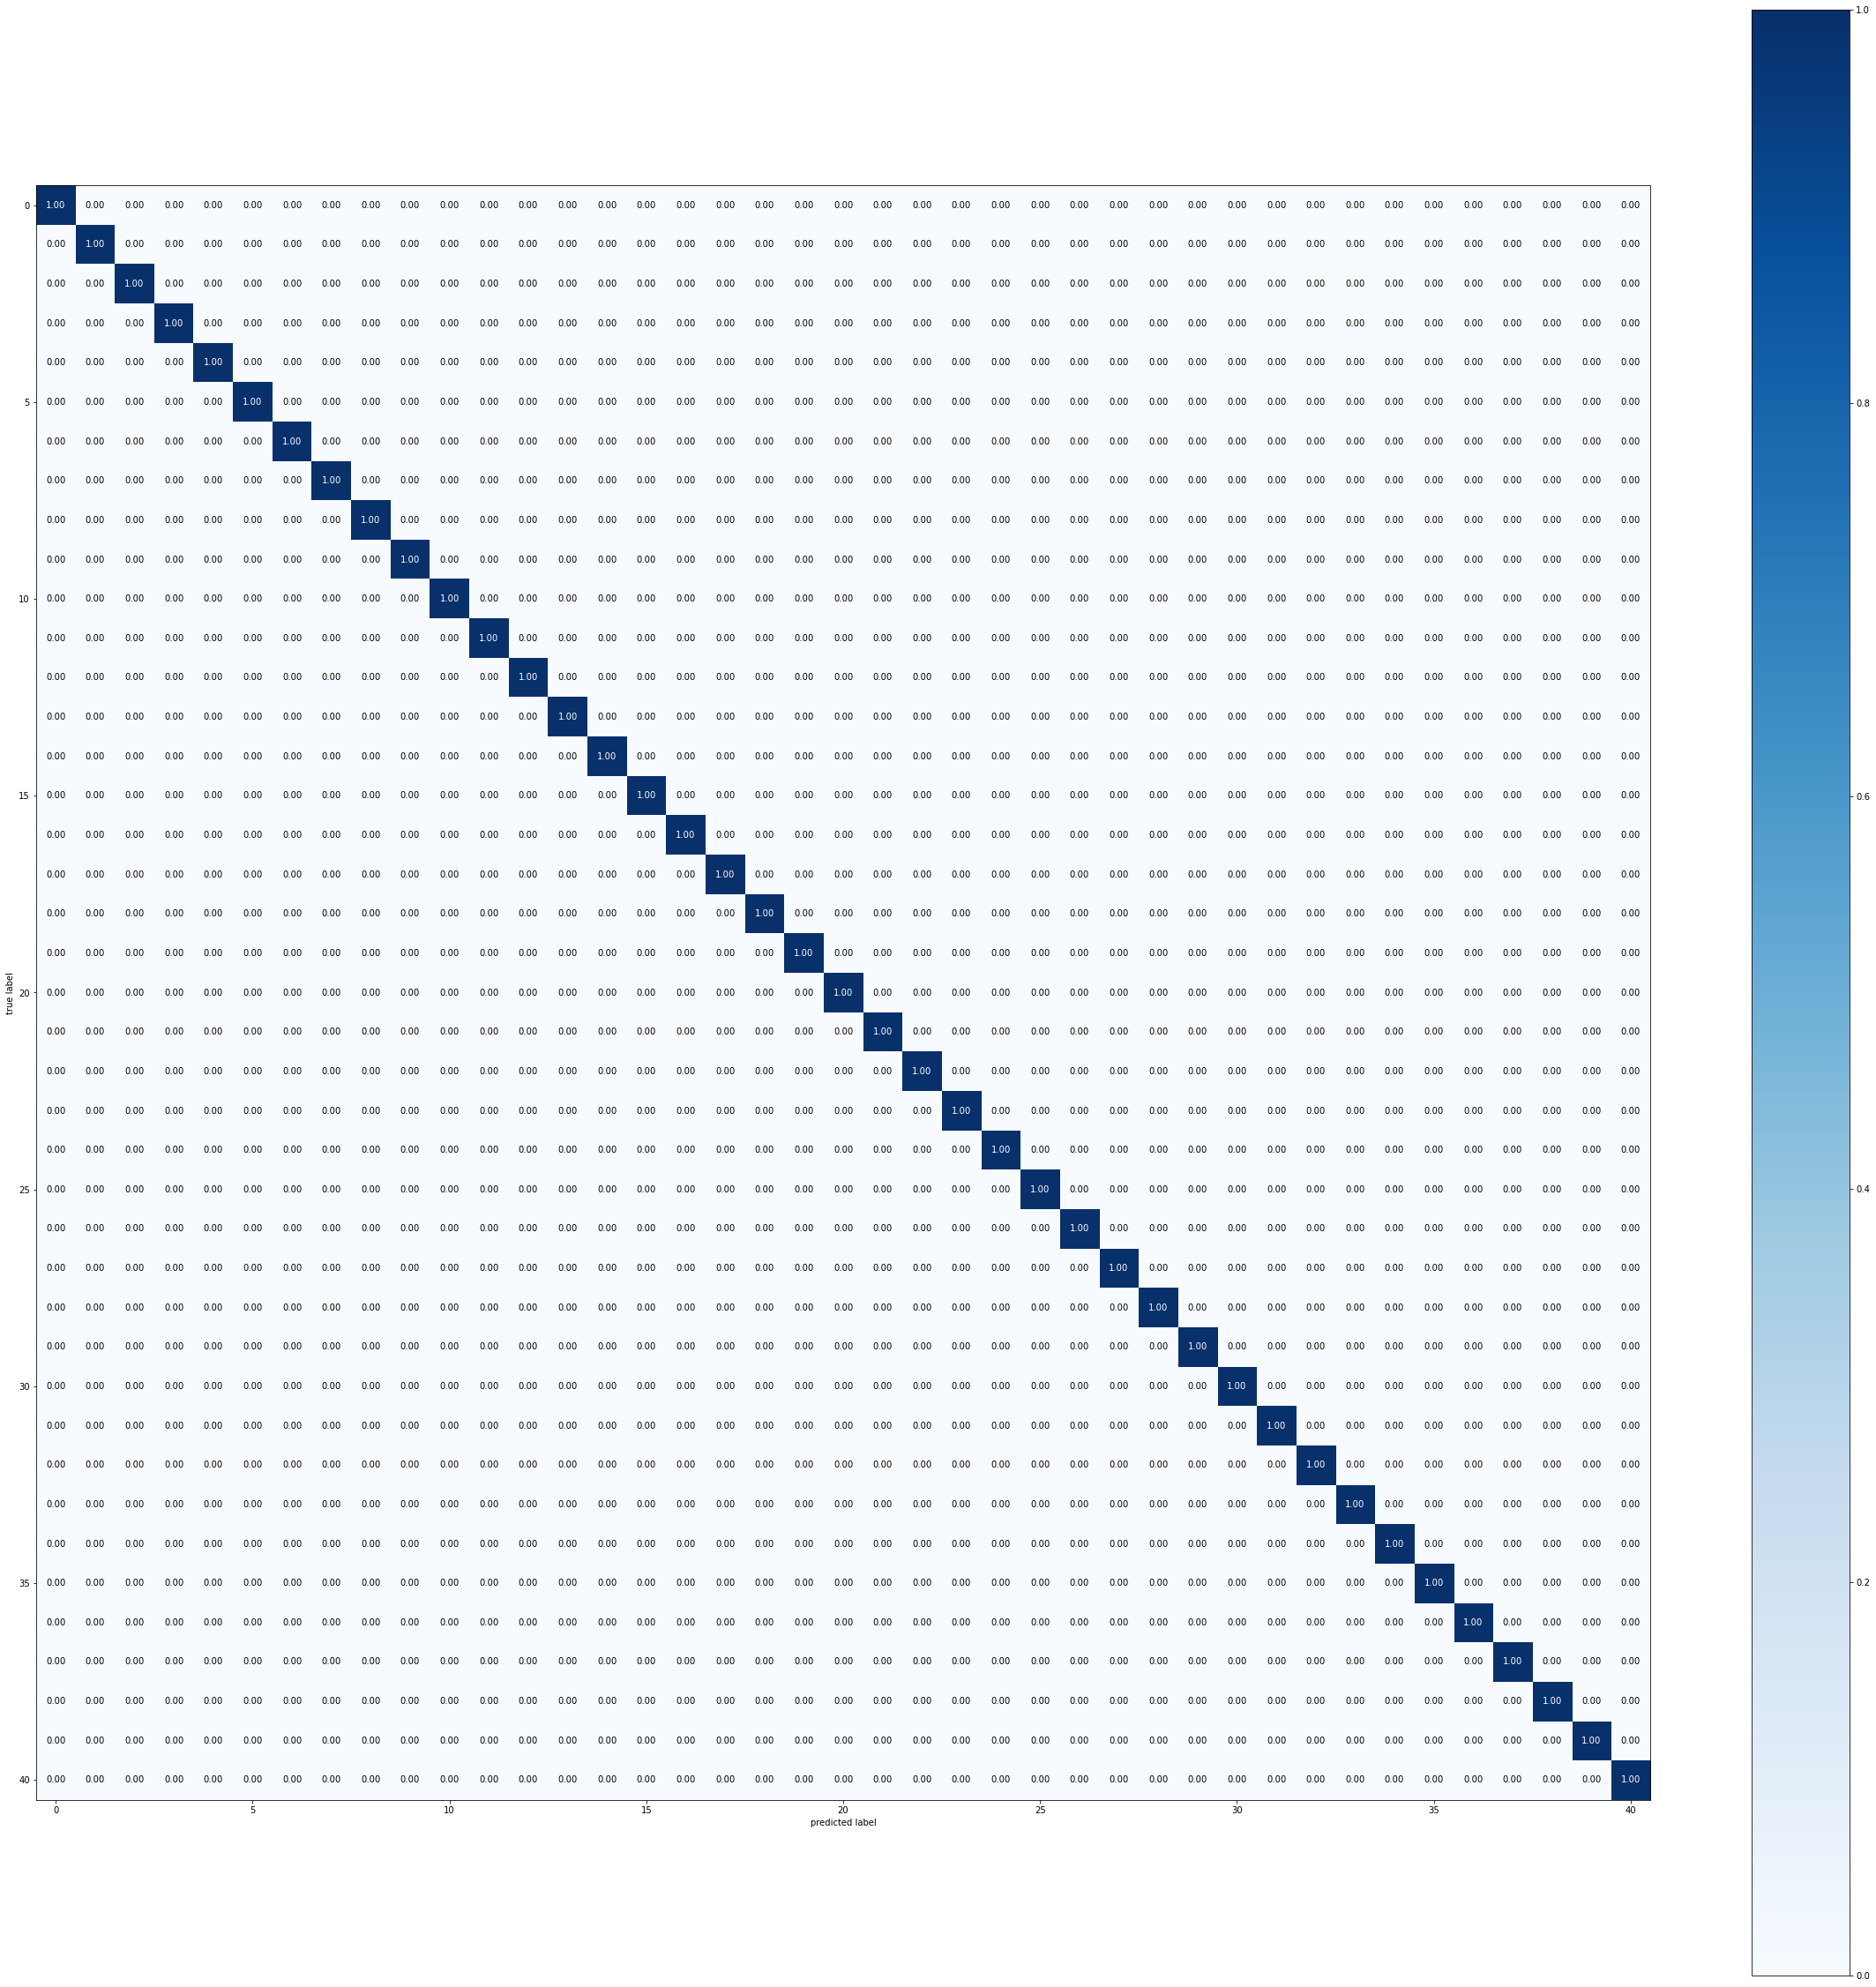

In [18]:
from mlxtend.plotting import plot_confusion_matrix

class_names = image_datasets['train'].classes
fig, ax = plot_confusion_matrix(conf_mat=matrix_1, 
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True,
                                #class_names=class_names,
                                figsize = (41,41),
                               ) #원본 값 : conf_mat=maxtrix_1
plt.show()

In [19]:
model = net 
#net = net.to(device) #Net().to(device)
#model.load_state_dict(torch.load(previous_ckpt))
#prune_model(model)
print(model)
params = sum([np.prod(p.size()) for p in model.parameters()])
print("Number of Parameters: %.5fM"%(params/1e6))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
#testing the model

In [21]:
dataiter = iter(dataloaders['test'])
images, labels = dataiter.next()
#PATH = './../AE_transient_6mm_new_2_no_noise.pth'

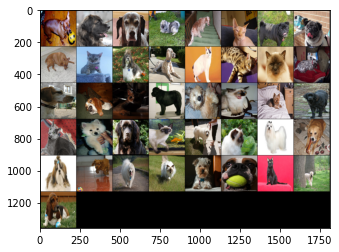

Goundtruth:  tensor(29) tensor(27) tensor(20) tensor(25) tensor(19) tensor(11) tensor(32) tensor(32) tensor(29) tensor(1) tensor(22) tensor(19) tensor(26) tensor(5) tensor(2) tensor(20)


In [22]:
 # print images
imshow(torchvision.utils.make_grid(images))
print('Goundtruth: ', ' '.join('%5s' % labels[j]
                              for j in range(16))) #range 원본 값 : 32

In [23]:
net.load_state_dict(torch.load(PATH))
model = nn.DataParallel(model)
images = images.to(device)
labels = labels.to(device)

In [24]:
outputs = net(images).to(device)


In [25]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % predicted[j]
                              for j in range(8)))
#range의 원본값 : 32

Predicted:  tensor(17, device='cuda:0') tensor(30, device='cuda:0') tensor(38, device='cuda:0') tensor(19, device='cuda:0') tensor(6, device='cuda:0') tensor(11, device='cuda:0') tensor(30, device='cuda:0') tensor(22, device='cuda:0')


In [26]:
class_correct = list(0. for i in range(41))
class_total = list(0. for i in range(41))
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs).to(device)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(41):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
for i in range(41):
    print('Accuracy of %5s : %0.2f %%' % (
        image_datasets['test'].classes[i], 100 * class_correct[i] / class_total[i]))


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs).to(device)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %0.2f%%' % (100 * correct / total))
